In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import torch
from torch import nn, optim
import torchmetrics

torch.__version__

'2.1.2'

In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
from pathlib import Path
data_path=Path('/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification')
train_path=data_path/'train'
val_path=data_path/'val'
test_path=data_path/'test'

Random image path: /kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/not fractured/13-rotated2.jpg
Image class: not fractured
Image height: 224
Image width: 224


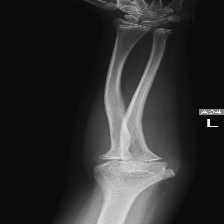

In [ ]:
import random
from PIL import Image

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(data_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

In [ ]:
train_transform=transforms.Compose([
    transforms.Resize((224,224)),
    ##Other transformers if needed
    transforms.ToTensor(),
])

val_transform=transforms.Compose([
    transforms.Resize((224,224)),
    ##Other transformers if needed
    transforms.ToTensor(),
])

test_transform=transforms.Compose([
    transforms.Resize((224,224)),
    ##Other transformers if needed
    transforms.ToTensor(),
])

In [ ]:
train_data=datasets.ImageFolder(root=train_path,transform=train_transform,target_transform=None)
# target_transforms= to perform on labels (if necessary)

val_data=datasets.ImageFolder(root=val_path,transform=train_transform,target_transform=None)

test_data=datasets.ImageFolder(root=test_path,transform=train_transform)

In [ ]:
print(f"Train data:\n{train_data}\nTest data:\n{test_data}\n Val data:\n{val_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 9246
    Root location: /kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 506
    Root location: /kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )
 Val data:
Dataset ImageFolder
    Number of datapoints: 829
    Root location: /kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val
    StandardTransform
Transform: Com

In [ ]:
# Get class names as a list
class_names = train_data.classes
class_names

['fractured', 'not fractured']

In [ ]:
train_data.classes, val_data.classes, test_data.classes

(['fractured', 'not fractured'],
 ['fractured', 'not fractured'],
 ['fractured', 'not fractured'])

In [ ]:
class_dict=train_data.class_to_idx
class_dict

{'fractured': 0, 'not fractured': 1}

In [ ]:
img, label = train_data[0][0], train_data[0][1]
# print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image shape: torch.Size([3, 224, 224])
Image datatype: torch.float32
Image label: 0
Label datatype: <class 'int'>


Original shape: torch.Size([3, 224, 224]) -> [color_channels, height, width]
Image permute shape: torch.Size([224, 224, 3]) -> [height, width, color_channels]


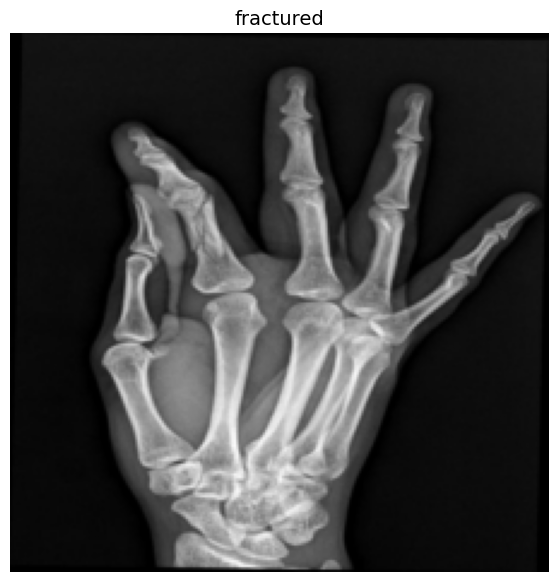

In [ ]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

train_dataloader=DataLoader(train_data,batch_size=64,shuffle=True, num_workers=os.cpu_count())

val_dataloader=DataLoader(val_data,batch_size=64,shuffle=False, num_workers=os.cpu_count())

test_dataloader=DataLoader(test_data,batch_size=64,shuffle=False, num_workers=os.cpu_count())

In [ ]:
train_dataloader, test_dataloader, val_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7d88304e5f00>,
 <torch.utils.data.dataloader.DataLoader at 0x7d88304e5480>)

In [ ]:
class FractureModel(nn.Module):
    def __init__(self,input_shape:int, output_shape:int, hidden_units:int=8):
        super().__init__()

        self.conv1=nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(hidden_units),
            nn.MaxPool2d(2,2),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units*2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(hidden_units*2),
            nn.MaxPool2d(2,2),
        )
        self.conv2=nn.Sequential(
            nn.Conv2d(in_channels=hidden_units*2, out_channels=hidden_units*3, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(hidden_units*3),
            nn.MaxPool2d(2,2),
            nn.Conv2d(in_channels=hidden_units*3, out_channels=hidden_units*4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(hidden_units*4),
            nn.MaxPool2d(2,2),
        )
        self.conv3=nn.Sequential(
            nn.Conv2d(in_channels=hidden_units*4, out_channels=hidden_units*4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(hidden_units*4),
            nn.MaxPool2d(2,2),
        )
        self.classifier=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*4*7*7,out_features=120),
            nn.ReLU(),
            nn.BatchNorm1d(120),
            nn.Dropout(0.3),
            nn.Linear(in_features=120,out_features=output_shape)
        )

    def forward(self, x:torch.Tensor) -> torch.Tensor:
    #         x=self.conv1(x)
    #         print(x.shape)
    #         x=self.conv2(x)
    #         print(x.shape)
    #         x=self.conv3(x)
    #         print(x.shape)
    #         x=self.classifier(x)
    #         print(x.shape)
    #         return x
            return self.classifier(self.conv3(self.conv2(self.conv1(x))))

In [ ]:
torch.manual_seed(42)
model=FractureModel(input_shape=3,output_shape=1,hidden_units=8).to(device)
model

FractureModel(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine

In [ ]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[1].unsqueeze(dim=0), label_batch[1]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model.eval()
with torch.inference_mode():
    pred = model(img_single.to(device))

# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.sigmoid(pred)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 224, 224])

Output logits:
tensor([[-0.0495]], device='cuda:0')

Output prediction probabilities:
tensor([[0.4876]], device='cuda:0')

Actual label:
0


In [ ]:
import torchinfo

torchinfo.summary(model,[1,3,224,224])

Layer (type:depth-idx)                   Output Shape              Param #
FractureModel                            [1, 1]                    --
├─Sequential: 1-1                        [1, 16, 56, 56]           --
│    └─Conv2d: 2-1                       [1, 8, 224, 224]          224
│    └─ReLU: 2-2                         [1, 8, 224, 224]          --
│    └─BatchNorm2d: 2-3                  [1, 8, 224, 224]          16
│    └─MaxPool2d: 2-4                    [1, 8, 112, 112]          --
│    └─Conv2d: 2-5                       [1, 16, 112, 112]         1,168
│    └─ReLU: 2-6                         [1, 16, 112, 112]         --
│    └─BatchNorm2d: 2-7                  [1, 16, 112, 112]         32
│    └─MaxPool2d: 2-8                    [1, 16, 56, 56]           --
├─Sequential: 1-2                        [1, 32, 14, 14]           --
│    └─Conv2d: 2-9                       [1, 24, 56, 56]           3,480
│    └─ReLU: 2-10                        [1, 24, 56, 56]           --
│    └─B

In [ ]:
def acc_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
def checkpoint(model, filename):
    torch.save(model.state_dict(), filename)
# torch.save({
#     'optimizer': optimizer.state_dict(),
#     'model': model.state_dict(),
# }, filename)

def resume(model, filename):
    model.load_state_dict(torch.load(filename))

In [ ]:
def train_step( model:nn.Module, dataloader:torch.utils.data.DataLoader, optimizer:optim.Optimizer, loss_fn:nn.Module, acc_fn):

    model.train()

    train_loss, train_acc = 0, 0
    for batch, (X,y) in enumerate(dataloader):

        X,y=X.to(device), y.to(device)
        y_logits=model(X).squeeze()

        loss=loss_fn(y_logits,y.float())
        train_loss+=loss.item()

        acc=acc_fn(y,torch.round(torch.sigmoid(y_logits)))
        train_acc+=acc

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [ ]:
def test_step( model:nn.Module, dataloader:torch.utils.data.DataLoader, loss_fn:nn.Module, acc_fn):

    model.eval()
    with torch.inference_mode():

        test_loss, test_acc = 0, 0
        for batch, (X,y) in enumerate(dataloader):

            X,y=X.to(device), y.to(device)

            y_logits=model(X).squeeze()

            loss=loss_fn(y_logits,y.float())
            test_loss+=loss.item()

            acc=acc_fn(y,torch.round(torch.sigmoid(y_logits)))
            test_acc+=acc

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [ ]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          acc_fn= acc_fn,
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }

    best_acc=-1

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                          acc_fn=acc_fn)
        val_loss, val_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,acc_fn=acc_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {val_loss:.4f} | "
            f"test_acc: {val_acc:.4f}"
        )
        if val_acc>best_acc:
            best_acc=val_acc
            checkpoint(model, "/kaggle/working/best_model.pth")

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 10


model=FractureModel(input_shape=3,output_shape=1,hidden_units=8).to(device)
model

# Setup loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_results = train(model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=val_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 1 | train_loss: 0.2160 | train_acc: 91.7658 | test_loss: 0.1797 | test_acc: 93.0111


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 2 | train_loss: 0.0430 | train_acc: 98.9009 | test_loss: 0.0805 | test_acc: 96.4553


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 3 | train_loss: 0.0279 | train_acc: 99.2241 | test_loss: 0.0979 | test_acc: 96.1479


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 4 | train_loss: 0.0145 | train_acc: 99.6336 | test_loss: 0.0572 | test_acc: 97.3321


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 5 | train_loss: 0.0175 | train_acc: 99.4504 | test_loss: 0.1731 | test_acc: 94.2091


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 6 | train_loss: 0.0240 | train_acc: 99.2565 | test_loss: 0.0497 | test_acc: 97.5902


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 7 | train_loss: 0.0074 | train_acc: 99.7737 | test_loss: 0.0332 | test_acc: 98.7803


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 8 | train_loss: 0.0047 | train_acc: 99.8599 | test_loss: 0.0297 | test_acc: 99.0385


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 9 | train_loss: 0.0047 | train_acc: 99.8815 | test_loss: 0.0260 | test_acc: 99.1587


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 10 | train_loss: 0.0061 | train_acc: 99.7845 | test_loss: 0.1326 | test_acc: 94.5618
Total training time: 191.319 seconds


In [ ]:
from typing import Dict, Tuple, List
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['val_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['val_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

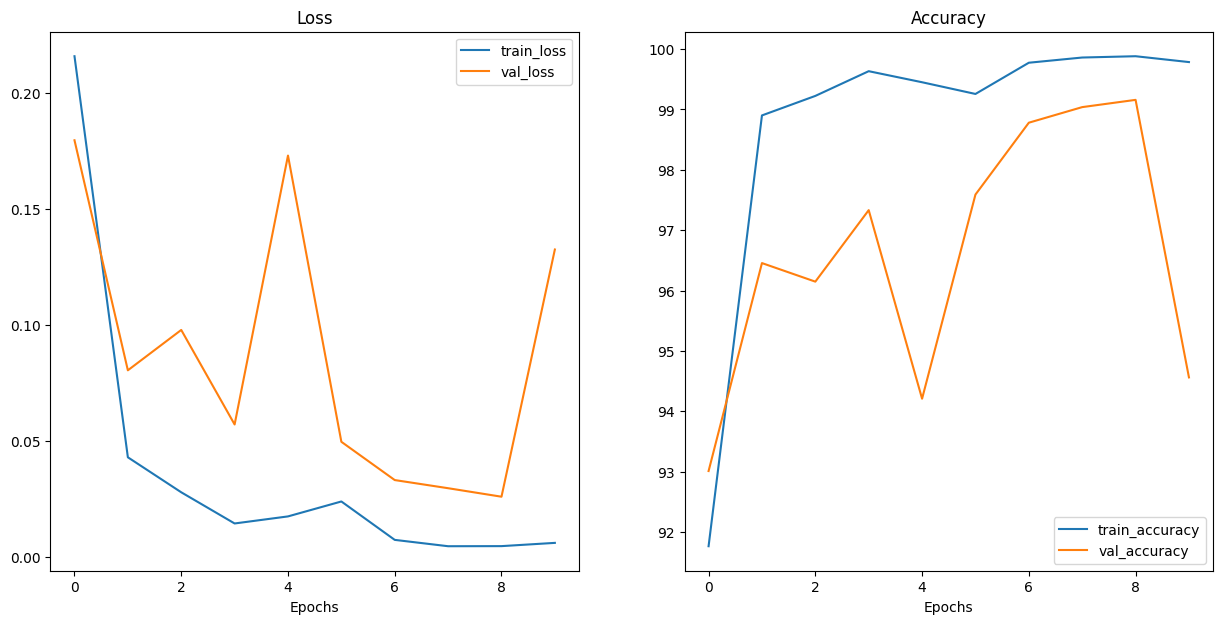

In [ ]:
plot_loss_curves(model_results)

In [ ]:
resume(model, "/kaggle/working/best_model.pth")
test_loss,test_acc=test_step(model=model,dataloader=test_dataloader,loss_fn=loss_fn,acc_fn=acc_fn)
test_loss,test_acc

(0.01622448877969873, 99.21875)

In [ ]:
torch.save(model,'/kaggle/working/model.pth')

In [ ]:
import torchvision
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
#     target_image = target_image / 255.

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.sigmoid(target_image_pred)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.round(target_image_pred_probs)

#     print(target_image_pred_probs)
    if target_image_pred_label>0:
        print(target_image_pred_probs)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label.cpu()} | Prob: {target_image_pred_probs.squeeze().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

    return target_image_pred_label.item()

In [ ]:
from PIL import Image  # Import PIL to handle image loading
import matplotlib.pyplot as plt

def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],  # Make sure class names are passed
                        transform=None,
                        device: torch.device = device,
                        threshold: float = 0.5):  # Add threshold argument
    """Makes a prediction on a target image and plots the image with its prediction."""

    # 1. Load the image using PIL
    target_image = Image.open(image_path).convert("RGB")  # Convert to RGB to ensure 3 channels

    # 2. Apply transformation if provided
    if transform:
        target_image = transform(target_image)

    # 3. Add a batch dimension to the image (for a single image)
    target_image = target_image.unsqueeze(dim=0)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Make a prediction
    target_image_pred = model(target_image.to(device))

    # 6. Convert logits to probabilities (for binary classification using sigmoid)
    target_image_pred_probs = torch.sigmoid(target_image_pred).item()  # Get as a float

    # 7. Apply the threshold to get the predicted class
    if target_image_pred_probs > threshold:
        predicted_class = class_names[1]  # Assume class_names[1] is "fracture"
    else:
        predicted_class = class_names[0]  # Assume class_names[0] is "no fracture"

    # 8. Print the prediction
    print(f"Predicted Probability: {target_image_pred_probs:.4f}")
    print(f"Predicted Class: {predicted_class}")

    # 9. Optionally, plot the image with the prediction label
    plt.imshow(target_image.squeeze().permute(1, 2, 0))  # Squeeze and permute to plot image
    plt.title(f"Prediction: {predicted_class}")
    plt.axis('off')
    plt.show()

Predicted Probability: 0.0000
Predicted Class: no_fracture


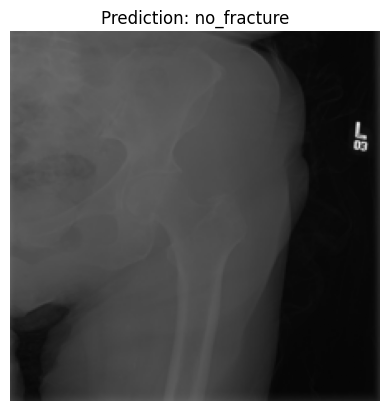

In [ ]:

from PIL import Image

# Define the new image transformation
custom_image_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3 channels
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Just pass the image path and let the function handle the transformation
image_path = '/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test/fractured/000151.png'

# Call the prediction and plotting function\
class_names = ["no_fracture", "fracture"]
pred_and_plot_image(model=model, class_names=class_names, image_path=image_path, transform=custom_image_transform)


# custom_image_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
# ])
# pred_and_plot_image(model=model,class_names=class_names,image_path=image_path,transform=custom_image_transform)

In [ ]:
# Save the model's state_dict after training
checkpoint(model, 'fracture_model_state_dict.pth')